In [1]:
#Kernel based on https://www.kaggle.com/kenseitrg/simple-fastai-exercise, for my training purpose

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("../input"))

['test', 'train', 'train.csv', 'sample_submission.csv']


In [2]:
# importing important libraries

from pathlib import Path
from fastai import *
from fastai.vision import *
import torch

In [3]:
# making the path of data_folder

data_folder = Path("../input")
data_folder.ls()

[PosixPath('../input/test'),
 PosixPath('../input/train'),
 PosixPath('../input/train.csv'),
 PosixPath('../input/sample_submission.csv')]

In [4]:
# reading the datasets

train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/sample_submission.csv")

# checking their shapes
print("Shape of train: ", train.shape)
print("Shape of test: ", test.shape)

Shape of train:  (17500, 2)
Shape of test:  (4000, 2)


In [5]:
# checking the head of the train set

train.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [6]:
# checking how many images contain cactus in it

train['has_cactus'].value_counts()

1    13136
0     4364
Name: has_cactus, dtype: int64

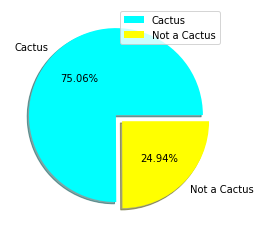

In [7]:
# making a pie chart for better understanding

size = [13136, 4364]
colors = ['cyan', 'yellow']
labels = ['Cactus', 'Not a Cactus']
explode = [0, 0.1]

plt.pie(size, colors = colors, labels = labels, explode = explode, shadow = True, autopct = '%.2f%%')
plt.axis('off')
plt.legend()
plt.show()

In [8]:
test_img = ImageList.from_df(test, path = data_folder/'test', folder='test')
trfm = get_transforms(do_flip = True, flip_vert = True, max_rotate = 10.0, max_zoom = 1.1,
                      max_lighting = 0.2, max_warp = 0.2, p_affine = 0.75, p_lighting = 0.75)
train_img = (ImageList.from_df(train, path = data_folder/'train', folder='train')
        .split_by_rand_pct(0.001) 
        .label_from_df()
        .add_test(test_img)
        .transform(trfm, size=128)
        .databunch(path='.', bs=64, device= torch.device('cuda:0'))
        .normalize(imagenet_stats)
       )


In [9]:
learn = create_cnn(train_img,models.densenet161, metrics=[error_rate, accuracy])

/opt/conda/lib/python3.6/site-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /tmp/.torch/models/densenet161-8d451a50.pth
115730790it [00:01, 81922176.81it/s]


In [10]:
lr = 3e-02
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.050052,0.154256,0.058824,0.941176,01:21
1,0.034862,0.000011,0.000000,1.000000,01:10
2,0.022629,0.000000,0.000000,1.000000,01:09
3,0.011790,0.000005,0.000000,1.000000,01:10
4,0.002495,0.000001,0.000000,1.000000,01:11


In [11]:
#learn.unfreeze()
#learn.lr_find()
#learn.recorder.plot()

In [12]:
#learn.fit_one_cycle(1, slice(1e-06))

In [13]:
#interp = ClassificationInterpretation.from_learner(learn)
#interp.plot_top_losses(9, figsize = (7,6))


In [14]:
preds,_ = learn.get_preds(ds_type = DatasetType.Test)

In [15]:
test.has_cactus = preds.numpy()[:, 0]
test.to_csv('submission.csv', index=False)  